In [1]:
# import packages
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# colormap stuff for plot generation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

/home/wyz5rge/.local/lib/python3.6/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


# Isochrone parameters

In [2]:
# define isochrone parameters
AKs = 0
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F162M', 'jwst,F182M']
filters = ['m_jwst_F162M', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# define log age array for isochrone grid
level_ages = np.linspace(1, 10, 19)
level_ages = np.multiply(level_ages, 1e6)
print(level_ages)
log_age_arr = np.log10(level_ages)
print(log_age_arr)

[ 1000000.  1500000.  2000000.  2500000.  3000000.  3500000.  4000000.
  4500000.  5000000.  5500000.  6000000.  6500000.  7000000.  7500000.
  8000000.  8500000.  9000000.  9500000. 10000000.]
[6.         6.17609126 6.30103    6.39794001 6.47712125 6.54406804
 6.60205999 6.65321251 6.69897    6.74036269 6.77815125 6.81291336
 6.84509804 6.87506126 6.90308999 6.92941893 6.95424251 6.97772361
 7.        ]


# Generate isochrone grid

In [4]:
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


# Function for calculating chi-square value based on photometric magnitudes

In [5]:
def chi_square_reverse_model(iso_grid, sample_mags):
    results = []
    
    for i in range(len(iso_grid)):
        for j in range(len(iso_grid[i].points)):
            arr = []
            chi_square = 0
            for k in range(len(sample_mags)):
                mag_obs = sample_mags[k]
                mag_exp = iso_grid[i].points[j][filters[k]]
                chi_square = chi_square + (((mag_obs - mag_exp) ** 2) / mag_exp)

            arr.append(chi_square)
            arr.append(iso_grid[i].points[j]['mass'])
            arr.append(10 ** log_age_arr[i])
            
            results.append(arr)
    
    sorted_results = sorted(results, key=sort_by_chi_square)
    
    report(sorted_results[:10])
    
def sort_by_chi_square(sub_list):
    return sub_list[0]

def report(output_arr):
    for i in range(len(output_arr)):
        print("Chi-square: " + str(output_arr[i][0]))
        print("Mass (Msun): " + str(output_arr[i][1]))
        print("Age (Myr): " + str(output_arr[i][2]))
        print()

# Define S284 sample magnitudes and run function

In [6]:
sample_mags = []

import csv
with open('s284-162-182.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        sample_mags.append(lines)

sample_mags.pop(0)

['\ufeffF162M', 'F182M']

In [7]:
# convert value array to numbers
for i in range(len(sample_mags)):
    for j in range(len(sample_mags[i])):
        sample_mags[i][j] = float(sample_mags[i][j])
print(sample_mags)

[[18.0957, 17.8409], [23.4467, 22.4409], [17.7037, 17.4619], [16.6887, 16.5989], [17.7007, 17.4209], [19.4097, 19.0389], [20.7147, 20.1869], [19.4917, 19.2589]]


In [8]:
for i in range(len(sample_mags)):
    chi_square_reverse_model(instances, sample_mags[i])
    print("==========================================")

Chi-square: 0.0011039713320437025
Mass (Msun): 0.4
Age (Myr): 8000000.000000003

Chi-square: 0.001320521820943425
Mass (Msun): 0.4
Age (Myr): 7500000.000000001

Chi-square: 0.001337966825558177
Mass (Msun): 0.4
Age (Myr): 8500000.000000002

Chi-square: 0.0015415809046580237
Mass (Msun): 0.3
Age (Myr): 4500000.000000003

Chi-square: 0.0016785835790339406
Mass (Msun): 0.3
Age (Myr): 4999999.999999999

Chi-square: 0.0022059055188041635
Mass (Msun): 0.4
Age (Myr): 9000000.000000007

Chi-square: 0.002226256447817502
Mass (Msun): 0.4
Age (Myr): 7000000.000000002

Chi-square: 0.0027537464708049164
Mass (Msun): 0.2
Age (Myr): 2499999.9999999995

Chi-square: 0.0027665889450831037
Mass (Msun): 0.17
Age (Myr): 2000000.0000000002

Chi-square: 0.0031553238248363787
Mass (Msun): 0.4
Age (Myr): 9499999.999999996

Chi-square: 0.034376415935832405
Mass (Msun): 0.015
Age (Myr): 7000000.000000002

Chi-square: 0.034419534500937675
Mass (Msun): 0.015
Age (Myr): 7500000.000000001

Chi-square: 0.034429468826

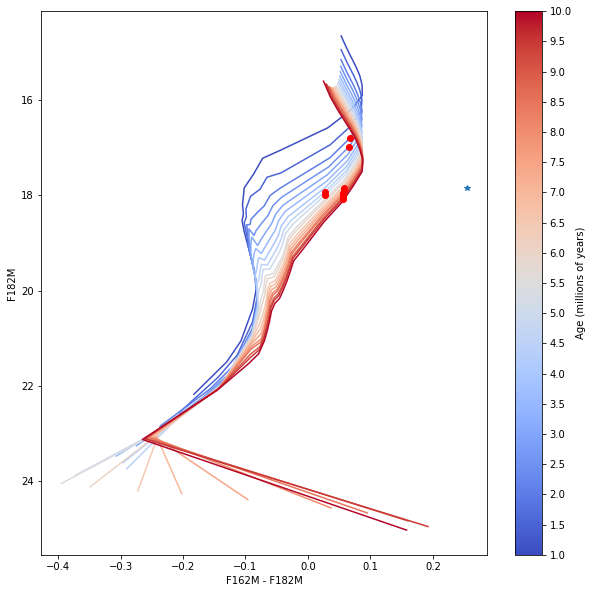

In [9]:
# Plot of estimated points from first trial run for first star
cmap = plt.get_cmap('coolwarm')

py.figure(figsize=(10, 10))

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
        instances[i].points[filters[1]], color=color, label='')

py.xlabel('F162M - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

py.plot(sample_mags[0][0] - sample_mags[0][1], sample_mags[0][1], '*')


idx = np.where( abs(instances[14].points['mass'] - 0.4) == min(abs(instances[14].points['mass'] - 0.4)) )[0]
py.plot(instances[14].points[idx[0]]['m_jwst_F162M'] - instances[14].points[idx[0]]['m_jwst_F182M'], 
        instances[14].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[13].points['mass'] - 0.4) == min(abs(instances[13].points['mass'] - 0.4)) )[0]
py.plot(instances[13].points[idx[0]]['m_jwst_F162M'] - instances[13].points[idx[0]]['m_jwst_F182M'], 
        instances[13].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[15].points['mass'] - 0.4) == min(abs(instances[15].points['mass'] - 0.4)) )[0]
py.plot(instances[15].points[idx[0]]['m_jwst_F162M'] - instances[15].points[idx[0]]['m_jwst_F182M'], 
        instances[15].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[7].points['mass'] - 0.3) == min(abs(instances[7].points['mass'] - 0.3)) )[0]
py.plot(instances[7].points[idx[0]]['m_jwst_F162M'] - instances[7].points[idx[0]]['m_jwst_F182M'], 
        instances[7].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[8].points['mass'] - 0.3) == min(abs(instances[8].points['mass'] - 0.3)) )[0]
py.plot(instances[8].points[idx[0]]['m_jwst_F162M'] - instances[8].points[idx[0]]['m_jwst_F182M'], 
        instances[8].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[16].points['mass'] - 0.4) == min(abs(instances[16].points['mass'] - 0.4)) )[0]
py.plot(instances[16].points[idx[0]]['m_jwst_F162M'] - instances[16].points[idx[0]]['m_jwst_F182M'], 
        instances[16].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
        
idx = np.where( abs(instances[12].points['mass'] - 0.4) == min(abs(instances[12].points['mass'] - 0.4)) )[0]
py.plot(instances[12].points[idx[0]]['m_jwst_F162M'] - instances[12].points[idx[0]]['m_jwst_F182M'], 
        instances[12].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[3].points['mass'] - 0.4) == min(abs(instances[3].points['mass'] - 0.4)) )[0]
py.plot(instances[3].points[idx[0]]['m_jwst_F162M'] - instances[3].points[idx[0]]['m_jwst_F182M'], 
        instances[3].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[2].points['mass'] - 0.4) == min(abs(instances[2].points['mass'] - 0.4)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'] - instances[2].points[idx[0]]['m_jwst_F182M'], 
        instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[17].points['mass'] - 0.4) == min(abs(instances[17].points['mass'] - 0.4)) )[0]
py.plot(instances[17].points[idx[0]]['m_jwst_F162M'] - instances[17].points[idx[0]]['m_jwst_F182M'], 
        instances[17].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

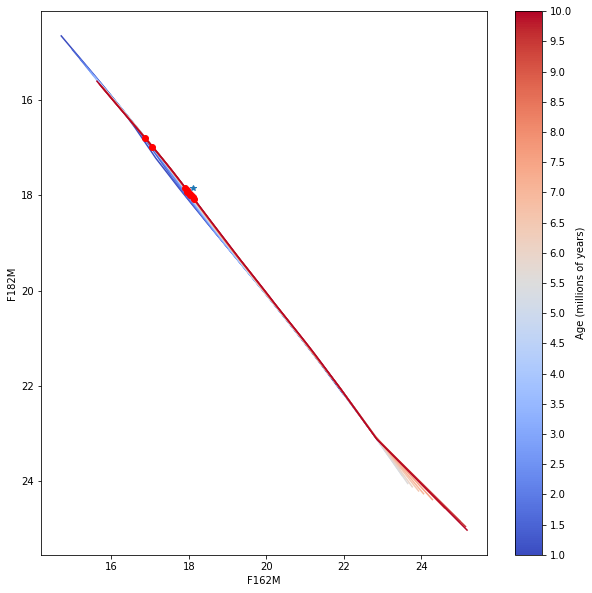

In [10]:
# Plot of estimated points from first trial run for first star
cmap = plt.get_cmap('coolwarm')

py.figure(figsize=(10, 10))

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]], instances[i].points[filters[1]], color=color, label='')

py.xlabel('F162M')
py.ylabel('F182M')
py.gca().invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

py.plot(sample_mags[0][0], sample_mags[0][1], '*')


idx = np.where( abs(instances[14].points['mass'] - 0.4) == min(abs(instances[14].points['mass'] - 0.4)) )[0]
py.plot(instances[14].points[idx[0]]['m_jwst_F162M'], instances[14].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[13].points['mass'] - 0.4) == min(abs(instances[13].points['mass'] - 0.4)) )[0]
py.plot(instances[13].points[idx[0]]['m_jwst_F162M'], instances[13].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[15].points['mass'] - 0.4) == min(abs(instances[15].points['mass'] - 0.4)) )[0]
py.plot(instances[15].points[idx[0]]['m_jwst_F162M'], instances[15].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[7].points['mass'] - 0.3) == min(abs(instances[7].points['mass'] - 0.3)) )[0]
py.plot(instances[7].points[idx[0]]['m_jwst_F162M'], instances[7].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[8].points['mass'] - 0.3) == min(abs(instances[8].points['mass'] - 0.3)) )[0]
py.plot(instances[8].points[idx[0]]['m_jwst_F162M'], instances[8].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[16].points['mass'] - 0.4) == min(abs(instances[16].points['mass'] - 0.4)) )[0]
py.plot(instances[16].points[idx[0]]['m_jwst_F162M'], instances[16].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
        
idx = np.where( abs(instances[12].points['mass'] - 0.4) == min(abs(instances[12].points['mass'] - 0.4)) )[0]
py.plot(instances[12].points[idx[0]]['m_jwst_F162M'], instances[12].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[3].points['mass'] - 0.4) == min(abs(instances[3].points['mass'] - 0.4)) )[0]
py.plot(instances[3].points[idx[0]]['m_jwst_F162M'], instances[3].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[2].points['mass'] - 0.4) == min(abs(instances[2].points['mass'] - 0.4)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'], instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[17].points['mass'] - 0.4) == min(abs(instances[17].points['mass'] - 0.4)) )[0]
py.plot(instances[17].points[idx[0]]['m_jwst_F162M'], instances[17].points[idx[0]]['m_jwst_F182M'], 'o', color='red')